# 実装したUCBが正しく動くかを人工データで確認

In [1]:
%load_ext autoreload

In [2]:
%autoreload
from policy import UCB, UCB1, UCBOffline
from sim import BernoulliBandit
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use("seaborn-whitegrid")

## 問題設定

In [3]:
n_arms = 2
T = 100000
log_size = 1
mu = np.array((0.01, 0.02))
n_rounds = T // log_size

## 実験

In [4]:
reward_generator = BernoulliBandit(n_arms=n_arms, mu=mu)
policy_dict = {
    "ucb": UCB(n_arms),
    "ucb1": UCB1(n_arms),
}

selected_arm_history = {key: list() for key in policy_dict.keys()}
for policy_name, policy in tqdm(policy_dict.items()):
    np.random.seed(1025)
    for n in tqdm(range(n_rounds), leave=False):
        arm = policy.select_arm()
        reward = reward_generator.pull(arm)
        policy.update(arm, reward)
        selected_arm_history[policy_name].append(arm)

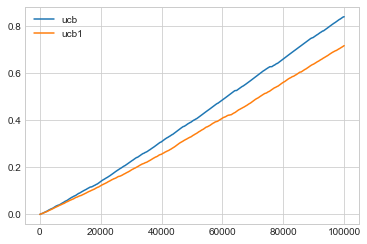

In [5]:
for policy_nam, policy in policy_dict.items():
    mask = np.array(selected_arm_history[policy_nam]) == reward_generator.best_arm
    plt.plot(np.cumsum(mask) / n_rounds, label=policy_nam)
plt.legend()

In [6]:
print(policy_dict["ucb1"].mean_rewards)
print(policy_dict["ucb1"].correction_factor)

[0.00990415 0.02059028]
[0.02859002 0.0179042 ]


In [7]:
print(policy_dict["ucb"].mean_rewards)
print(policy_dict["ucb"].correction_factor)

[0.00988478 0.02064981]
[0.01903757 0.00827248]


## 実験2 offline 学習
ログが1000件ずつ与えられ、上から順にログのアームと選択したアームが等しいデータのみで学習

In [8]:
n_arms = 2
T = 1000000
log_size = 1000
mu = np.array((0.01, 0.02))
n_rounds = T // log_size

In [9]:
reward_generator = BernoulliBandit(n_arms=n_arms, mu=mu)
policy_dict = {"ucb": UCB(n_arms), "ucb1": UCB1(n_arms)}

selected_arm_history = {key: list() for key in policy_dict.keys()}
cnt = 0
for policy_name, policy in tqdm(policy_dict.items()):
    np.random.seed(1025)
    for n in tqdm(range(n_rounds), leave=False):
        # offline phase (inference)
        arm = policy.select_arm()  # armの選択
        selected_arm_history[policy_name].append(arm)
        # online phase
        ## log size分報酬を取得。選択しなかったアームの報酬は得られない
        log = []
        for _ in range(log_size):
            log.append(reward_generator.pull(arm))
        log = np.asarray(log)
        # offline phase (learing)
        for reward in log:
            policy_arm = policy.select_arm()
            if arm == policy_arm:
                policy.update(arm, reward)
                cnt += 1

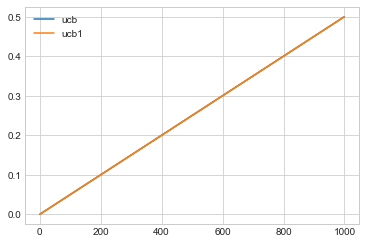

In [10]:
for policy_nam, policy in policy_dict.items():
    mask = np.array(selected_arm_history[policy_nam]) == reward_generator.best_arm
    plt.plot(np.cumsum(mask) / n_rounds, label=policy_nam)
plt.legend()

In [11]:
print(policy_dict["ucb"].mean_rewards)
print(policy_dict["ucb"].correction_factor)

[0.01284109 0.01612903]
[0.07587879 0.07252241]


In [12]:
print(policy_dict["ucb1"].mean_rewards)
print(policy_dict["ucb1"].correction_factor)

[0.01088929 0.01541096]
[0.15979102 0.15521073]


### offline学習でも報酬をログの報酬の平均とする実験

In [13]:
# 設定は同じ
n_arms = 2
T = 1000000
log_size = 1000
mu = np.array((0.01, 0.02))
n_rounds = T // log_size

In [14]:
reward_generator = BernoulliBandit(n_arms=n_arms, mu=mu)
policy_dict = {
    "ucb": UCB(n_arms),
    "ucb1": UCB1(n_arms),
    "ucb_offline": UCBOffline(n_arms),
}

selected_arm_history = {key: list() for key in policy_dict.keys()}
cnt = 0
for policy_name, policy in tqdm(policy_dict.items()):
    np.random.seed(1026)
    for n in tqdm(range(n_rounds), leave=False):
        # offline phase (inference)
        arm = policy.select_arm()  # armの選択
        selected_arm_history[policy_name].append(arm)
        # online phase
        ## log size分報酬を取得。選択しなかったアームの報酬は得られない
        log = []
        for _ in range(log_size):
            log.append(reward_generator.pull(arm))
        log = np.asarray(log)
        # offline phase (learing)
        if policy_name == "ucb_offline":
            policy.update(arm, log)
        else:
            reward = log.mean()  # 平均を報酬とする（つまりctrが報酬）
            policy.update(arm, reward)

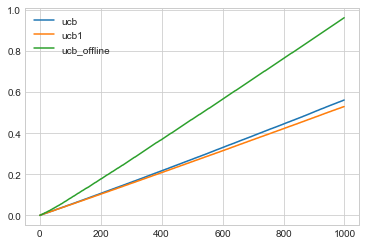

In [15]:
for policy_nam, policy in policy_dict.items():
    mask = np.array(selected_arm_history[policy_nam]) == reward_generator.best_arm
    plt.plot(np.cumsum(mask) / n_rounds, label=policy_nam)
plt.legend()

In [16]:
print(policy_dict["ucb"].mean_rewards)
print(policy_dict["ucb"].correction_factor)

[0.0099385  0.02015686]
[0.08869951 0.07846429]


In [17]:
print(policy_dict["ucb1"].mean_rewards)
print(policy_dict["ucb1"].correction_factor)

[0.01021444 0.02004348]
[0.17126673 0.16160531]


In [18]:
print(policy_dict["ucb_offline"].mean_rewards)
print(policy_dict["ucb_offline"].correction_factor)

[0.00946154 0.02010198]
[0.01330872 0.00268106]


## 実験3 logがランダムな長さで与えられる場合
実験2ではログは1000件ずつ与えられていたが、100 ~ 1000件のうちランダムにログ件数が得られるという実験の設定

In [26]:
n_arms = 2
T = 1000000
mu = np.array((0.01, 0.015))

In [27]:
reward_generator = BernoulliBandit(n_arms=n_arms, mu=mu)
policy_dict = {
    "ucb": UCB(n_arms),
    "ucb1": UCB1(n_arms),
    "ucb_offline": UCBOffline(n_arms),
}
selected_arm_history = {key: list() for key in policy_dict.keys()}
for policy_name, policy in tqdm(policy_dict.items()):
    np.random.seed(1025)
    cnt = 0
    n_rounds = 0
    while cnt <= T:
        log_size = np.random.randint(1, 1000)
        # offline phase (inference)
        arm = policy.select_arm()  # armの選択
        selected_arm_history[policy_name].append(arm)
        # online phase
        ## log size分報酬を取得。選択しなかったアームの報酬は得られない
        log = []
        for _ in range(log_size):
            log.append(reward_generator.pull(arm))
        log = np.asarray(log)
        # offline phase (learing)
        if policy_name == "ucb_offline":
            policy.update(arm, log)
        else:
            reward = log.mean()  # 平均を報酬とする（つまりctrが報酬）
            policy.update(arm, reward)
        cnt += log_size
        n_rounds += 1

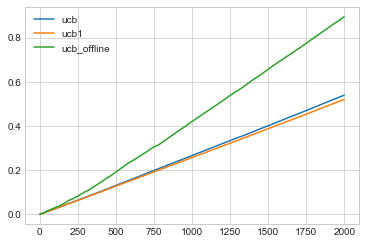

In [28]:
for policy_nam, policy in policy_dict.items():
    mask = np.array(selected_arm_history[policy_nam]) == reward_generator.best_arm
    plt.plot(np.cumsum(mask) / n_rounds, label=policy_nam)
plt.legend()

In [29]:
print(policy_dict["ucb"].mean_rewards)
print(policy_dict["ucb"].correction_factor)

[0.01022477 0.01511585]
[0.06423737 0.05934811]


In [30]:
print(policy_dict["ucb1"].mean_rewards)
print(policy_dict["ucb1"].correction_factor)

[0.01008045 0.0151392 ]
[0.12590364 0.1208432 ]


In [31]:
print(policy_dict["ucb_offline"].mean_rewards)
print(policy_dict["ucb_offline"].correction_factor)

[0.00986141 0.01506001]
[0.0079528  0.00278468]
